# All Data

# Setup

## Import Libraries

In [1]:
import os
import re

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython import display

from vpt.features.features import *
import vpt.utils.image_processing as ip
import vpt.settings as s

%load_ext autoreload
%autoreload 2

## Helper Functions

### Visualize Hands

In [2]:
def get_hand_imgs(lh, rh):
    dmap_lh, dmap_rh = lh.get_original(), rh.get_original()
    mask_lh, mask_rh = lh.get_mask(), rh.get_mask()
        
    img_lh, img_rh = (ip.normalize(dmap_rh)*255).astype('uint8'), (ip.normalize(dmap_rh)*255).astype('uint8')
    img_lh, img_rh = cv2.bitwise_and(img_lh, img_lh, mask=mask_lh), cv2.bitwise_and(img_rh, img_rh, mask=mask_rh)
    
    return img_lh, img_rh
    


### Generate Dataset

In [3]:
def init_hand_detector(M, radius, n_samples, folder, ftype, annotation_file):
    annotations = load_annotations(annotation_file)

    # generate or load model
    segmentation_model_path = "data/rdf/trainedmodels/p4_M%i_rad%0.1f" % (M, radius)
    rdf_hs = load_hs_model('p4', M, radius, n_samples, refreshHD, segmentation_model_path, masks="seq_masks")

    fs = FileStream(folder, ftype, annotations=annotations, ignore=True)
    hd = HandDetector(rdf_hs)
    
    return fs, hd, annotations

In [4]:
def generate_data(fs, hd, annotations, show=False):

    X_lh = []
    y_lh = []
    training_idxs_lh = []

    X_rh = []
    y_rh = []
    training_idxs_rh = []

    filenames = []

    hg = HandGenerator(fs, hd, annotations)

    hgen = hg.hand_generator(debug=True)
    i = 0
    init_show = False
    for lh, rh in hgen:
        if lh.label() != None and rh.label() != None:
            
            # display
            if show:
                img_lh, img_rh = get_hand_imgs(lh, rh)
                if not init_show:
                    plt.figure(figsize=(12,4))
                    plt.subplot(121)
                    disp_lh = plt.imshow(img_lh)
                    
                    plt.subplot(122)
                    disp_rh = plt.imshow(img_rh)
                    
                    init_show = True
                else:
                    print(lh.get_fpath())
                    disp_lh.set_data(img_lh)
                    disp_rh.set_data(img_rh)
                    plt.draw()
                    
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                    print(lh.get_fpath())
                    plt.pause(0.001)
                    
                

            if (s.participant != "p0" and s.participant != "p9") and re.search("p[\d]s", lh.get_fpath()) is not None:
                print("training idx:", i)
            elif (s.participant == "p0" and "p0a" in lh.get_fpath() or "p0b" in lh.get_fpath()) or (s.participant == "p9" and "p9a" in lh.get_fpath() or "p9b" in lh.get_fpath()):
                training_idxs_lh.append(i)

            filenames.append(lh.get_fpath())
            y_lh.append(lh.label())
            X_lh.append(extract_features(lh.get_hand_img(), feature_type, n_slices=n_slices))
            
            i+=1
            
        else:
            raise RuntimeWarning("Warning: No label found for hands")

    X_lh = np.array(X_lh)
    y_lh = np.array(y_lh)
    filenames = np.array(filenames)

    training_mask_lh = np.zeros((len(y_lh),), dtype=bool)
    training_mask_lh[training_idxs_lh] = True
    
    return X_lh, y_lh, training_mask_lh, filenames

### Load/Save Dataset

In [5]:
def save_data(X_lh, y_lh, training_mask_lh, filenames, participant, M, radius, feature_type):

    data_path = os.path.join("data/posture", participant, "models/M{}_rad{:0.1f}_{}".format(M, radius, feature_type))
    np.save(data_path + ".full_data_lh.npy", np.hstack((X_lh, np.expand_dims(y_lh, 1))))
    np.save(os.path.join("data/posture", participant, "models/training_mask_lh.npy"), training_mask_lh)
    np.save(os.path.join("data/posture", participant, "models/filenames.npy"), filenames)

In [6]:
def load_data(participant, M, radius, feature_type):
    data_path = os.path.join("data/posture", participant, "models/M{}_rad{:0.1f}_{}".format(M, radius, feature_type))
    data_lh = np.load(data_path + ".full_data_lh.npy")
    training_mask_lh = np.load(os.path.join("data/posture", participant, "models/training_mask_lh.npy"))
    filenames = np.load(os.path.join("data/posture", participant, "models/filenames.npy"))

    X_lh = data_lh[:, :-1].squeeze()
    y_lh = data_lh[:, -1].squeeze()
    
    return X_lh, y_lh, training_mask_lh, filenames

# Loading Data

In [37]:
# Initialize Data Loading Parameters
s.participant = "all"
s.sensor = "realsense"
s.note = "all_data_11_30"

ftype = "bin"
folder = "data/posture/all/"
annotation_file = "data/posture/all/annotations.txt"

refreshHD = False
refreshCLF = True

# RDF Parameters
M = 3
radius = .3
n_samples = 500

# Posture Parameters
feature_type = "shog"
n_slices = 20

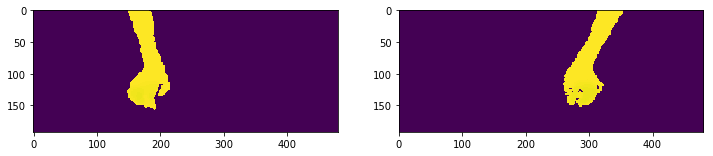

data/posture/all/p4/p4e/000416.bin
Done

Saving Data...
Done


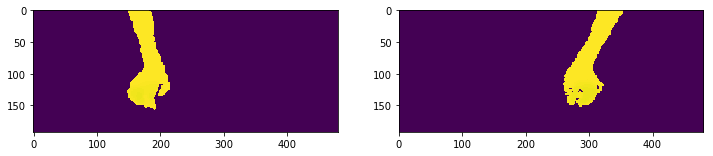

In [43]:
# generate and save data
print("Setting up Hand Dectector...")
fs, hd, annotations = init_hand_detector(M, radius, n_samples, folder, ftype, annotation_file)
print("Done")
print()
print("Generating Data..")
X_lh, y_lh, training_mask_lh, filenames = generate_data(fs, hd, annotations, show=True)
print("Done")
print()
print("Saving Data...")
save_data(X_lh, y_lh, training_mask_lh, filenames, s.participant, M, radius, feature_type)
print("Done")

In [40]:
# load existing data
X_lh, y_lh, training_mask_lh, filenames = load_data(s.participant, M, radius, feature_type)

# Classification

### Libraries

In [44]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

## Data Setup

In [45]:
## find all "static" data so we can ignore for now
r = re.compile('p[\d]s')
# r2 = re.compile('p[\d]d')

# remove p#s data
vmatch = np.vectorize(lambda x:bool(r.search(x)))
rem_static = vmatch(filenames)

X_lh, y_lh, filenames = X_lh[~rem_static], y_lh[~rem_static], filenames[~rem_static]

# seperate p3 from data
r_p3 = re.compile('/p3/')
vmatch = np.vectorize(lambda x:bool(r_p3.search(x)))
sel = vmatch(filenames)

X_lh2, y_lh2 = X_lh[~sel], y_lh[~sel]

#augment data with SMOTE (but first split it so we have some good testing data)
# X_train_lh, X_test_lh, y_train_lh, y_test_lh = train_test_split(X_lh2, y_lh2, test_size=.20)
X_train_lh, X_test_lh, y_train_lh, y_test_lh = X_lh2, X_lh[sel], y_lh2, y_lh[sel]
X_smote_lh, y_smote_lh = SMOTE(kind='svm').fit_sample(X_train_lh, y_train_lh)

SMOTE: (11459, 160) (11459,)
TEST: (2650, 160) (2650,)


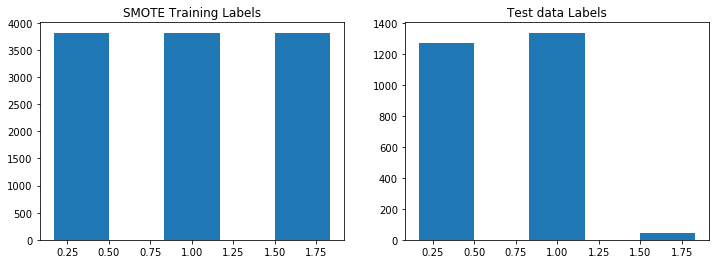

In [46]:
# Plot Data sets
print("SMOTE:", X_smote_lh.shape, y_smote_lh.shape)
print("TEST:", X_test_lh.shape, y_test_lh.shape)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(y_smote_lh, bins=3, rwidth=.5)
plt.title("SMOTE Training Labels")

plt.subplot(122)
plt.hist(y_test_lh, bins=3, rwidth=.5)
plt.title("Test data Labels")

## SVM

In [47]:
# Using Models selected in previous notebook (see model selection)
C = 100
gamma = .1
kernel = 'rbf'
clf_svm = SVC(C=C, gamma=gamma, kernel=kernel)

In [48]:
scores = cross_val_score(clf_svm, X_smote_lh, y_smote_lh)

In [49]:
print("Scores:", scores)
print("Avg Score:", np.average(scores))

Scores: [ 0.85344151  0.7475779   0.73160513]
Avg Score: 0.777541513222


In [50]:
clf_svm.fit(X_smote_lh, y_smote_lh)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
y_true, y_pred = y_test_lh, clf_svm.predict(X_test_lh)
print("Test Set Accuracy Score:", accuracy_score(y_true, y_pred))
print("Confustion Matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Test Set Accuracy Score: 0.581886792453
Confustion Matrix:
 [[987 280   0]
 [775 555   6]
 [ 30  17   0]]
             precision    recall  f1-score   support

          0       0.55      0.78      0.65      1267
          1       0.65      0.42      0.51      1336
          2       0.00      0.00      0.00        47

avg / total       0.59      0.58      0.56      2650



## NN

In [52]:
# Using model parameters found in model selection notebook
activation = "relu"
alpha = .0035
hidden_layer_sizes = (256,256)
solver = "adam"

In [53]:
clf_mlp = MLPClassifier(activation=activation, alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, solver=solver)

In [54]:
scores_mlp = cross_val_score(clf_mlp, X_smote_lh, y_smote_lh)
print("Scores:", scores_mlp)
print("Avg Score:", np.average(scores_mlp))

Scores: [ 0.85684376  0.74993454  0.75490966]
Avg Score: 0.78722931941


In [55]:
clf_mlp.fit(X_smote_lh, y_smote_lh)

MLPClassifier(activation='relu', alpha=0.0035, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256, 256), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [56]:
y_true, y_pred = y_test_lh, clf_mlp.predict(X_test_lh)
print("Test Set Accuracy Score:", accuracy_score(y_true, y_pred))
print("Confustion Matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Test Set Accuracy Score: 0.554716981132
Confustion Matrix:
 [[884 383   0]
 [742 586   8]
 [ 29  18   0]]
             precision    recall  f1-score   support

          0       0.53      0.70      0.61      1267
          1       0.59      0.44      0.50      1336
          2       0.00      0.00      0.00        47

avg / total       0.55      0.55      0.54      2650

